<a id='top'></a>

# Academic Mastery Study

**Improve academic evaluations by predicting whether a student will answer the next test question correctly.** Students taking advantage of practice exercises through various software applications seek an evaluation of their preparedness for formal academic assessments. They would like an an accurate evaluation of any gaps in knowledge and skills without sitting through exercises that repeatedly test established proficiencies and difficulties. The goal is to help test developers build an application that precisely evaluates competencies so that fewer demonstrations of proficiency can accurately determine mastery.

## THE DATA
---
Available from the [Grockit competition on Kaggle]( https://www.kaggle.com/c/WhatDoYouKnow/data).
```python
category_labels.csv
test.csv
training.csv
```
Test data does not include `answer_id` or `outcome` (from which correctness could be determined).

The test/training split is derived by finding *users who answered at least 6 questions*, taking **one** of their answers (uniformly random, *from their 6th question to their last*), and inserting it into the **test set**.
* Any *later answers by this user* are removed, 
* and any *earlier answers are included in the **training set***.  
* All answers *from users not in the test set are also used for the training set* (as they may be useful in estimating question parameters or baseline ability distributions).

The **test data** distribution is thus different from **training data** in ways that may be significant.  
* First, it does not include 'timeout' or 'skipped' outcomes: all test results are from the student actually answering the question.  
* Second, it is biased towards users with more questions in the training set and biased towards their later answers.  
* Third, it is one entry per user, so the distribution of various aspects of the data (such as correct/incorrect) is over users, not over all answered questions.

---

**`correct`: `0` or `1` [TARGET] - indicates whether the student answered the question correctly.**

**`user_id`**: [[**categorical**]](#user_id) - anonymized numeric identifier for the user answering the question.
       
**`question_id`**: [[**categorical**]](#question_id) - a numeric identifier for the question being answered.
     
**`question_type`**: [[**categorical**]](#question_type) - a numeric code representing the type of question; either `MultipleChoiceOneCorrect` (`0`) for multiple choice, or `SPR` (`1`) for free response questions.
   
**`group_name`**: [[**categorical**]](#group_name) - a numeric code representing the group of the question `{'act':0, 'gmat':1, 'sat':2}`.

`group_name`

     track_name   
        
        subtrack_name
    
            tag_string

**`track_name`**: [[**categorical**]](#track_name) - the numeric code for the track within the test this question is associated with (mappings from category fields to numeric values are in `category_labels.csv`).

**`subtrack_name`**: [[**categorical**]](#subtrack_name) - the numeric code for the subtrack within the track this question is associated with (mappings from category fields to numeric values are in category_labels.csv).

**`tag_string`**: [[**categorical**]](#tag_string) - a space-separated list of tag ids this question has been tagged with (mappings from category fields to numeric values are in category_labels.csv).

**`round_started_at`**: [[**numeric**]](#round_started_at) [use this as reference date] - a UTC timestamp indicating when the user saw the question.

**`answered_at`**: [[**numeric**]](#answered_at) [minutes from reference date] - a UTC timestamp indicating when the user answered the question (NULL if not answered).

**`deactivated_at`**: [[**numeric**]](#deactivated_at) [minutes from reference date] - a UTC timestamp indicating when the round finished, either because of being answered or timing out.

**`game_type`**: [[**categorical**]](#game_type) - indicates the type of game/study session (mappings from category fields to numeric values are in category_labels.csv).

**`num_players`**: [[**numeric**]](#num_players) - the number of players in the game at the time (multiple people can be viewing the same question simultaneously).

**`date_of_test`**: [[**numeric**]](#date_of_test) [minutes from reference date] - the date the user entered as their expected test date (if entered).

## DATA WRANGLING
---
Download the `grockit_all_data.zip` file from the [Grockit competition on Kaggle](https://www.kaggle.com/c/WhatDoYouKnow/data). Import and inspect raw training data. Isolate relevant variables and organize dataframe. Rectify missing, invalid or corrupted values.

### Import Packages & Training Dataset

In [1]:
import numpy as np
import pandas as pd
from scipy import stats, integrate
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [2]:
# Download grockit_all_data.zip from https://www.kaggle.com/c/WhatDoYouKnow/data,
# and save in the project's raw data directory.

# Read and save CSV file as dataframe, converting date strings to datetime objects:
df = pd.read_csv('../data/raw/training.csv', parse_dates=True) 

### Inspect DataFrame

In [3]:
# Inspect the current state of the dataset:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4851475 entries, 0 to 4851474
Data columns (total 17 columns):
correct             int64
outcome             int64
user_id             int64
question_id         int64
question_type       int64
group_name          int64
track_name          int64
subtrack_name       int64
tag_string          object
round_started_at    object
answered_at         object
deactivated_at      object
answer_id           int64
game_type           int64
num_players         int64
date_of_test        object
question_set_id     int64
dtypes: int64(12), object(5)
memory usage: 629.2+ MB


The raw training dataset contains 17 variables (columns) and 4851475 observations (rows/entries).

In [4]:
# Inspect the structure and first 5 observations of the raw dataset:
df.head()

,correct,outcome,user_id,question_id,question_type,group_name,track_name,subtrack_name,tag_string,round_started_at,answered_at,deactivated_at,answer_id,game_type,num_players,date_of_test,question_set_id
0,0,2,85818,5560,0,1,5,14,222 233 240 246,2010-08-18 20:17:13,2010-08-18 20:18:18,2010-08-18 20:18:18,6540,7,1,NaN,1567
1,1,1,85818,4681,0,1,5,0,24 49,2010-08-18 20:19:12,2010-08-18 20:20:34,2010-08-18 20:20:34,4742,7,1,NaN,1227
2,1,1,85818,1529,0,1,5,0,31 49,2010-08-18 20:20:42,2010-08-18 20:21:56,2010-08-18 20:21:56,4309,7,1,NaN,1148
3,1,1,85818,2908,0,1,5,0,31 49,2010-08-18 20:22:03,2010-08-18 20:23:05,2010-08-18 20:23:05,4408,7,1,NaN,1168
4,1,1,85818,1773,0,1,5,11,183 194 207,2010-08-18 20:23:11,2010-08-18 20:26:08,2010-08-18 20:26:08,10822,7,1,NaN,2318


In [5]:
# Inspect the last 5 observations:
df.tail()

,correct,outcome,user_id,question_id,question_type,group_name,track_name,subtrack_name,tag_string,round_started_at,answered_at,deactivated_at,answer_id,game_type,num_players,date_of_test,question_set_id
4851470,1,1,58569,1633,0,1,4,9,47 82 118 161,2009-10-18 17:08:32,2009-10-18 17:09:06,2009-10-18 17:09:06,8811,7,1,2009-09-18,2017
4851471,0,4,58569,1775,0,1,4,1,4 52 135 262,2009-10-18 17:09:24,NaN,2009-10-18 17:10:03,25553,7,1,2009-09-18,2406
4851472,0,4,131842,1655,0,2,8,5,106 130 164,2010-04-19 23:13:02,NaN,2010-04-19 23:13:37,25553,7,5,NaN,368
4851473,0,4,131842,544,0,2,8,3,101 103 134 280,2010-04-19 23:13:48,NaN,2010-04-19 23:14:35,25553,7,5,NaN,470
4851474,0,4,52513,1272,0,2,7,13,239 245,2010-05-18 14:32:59,NaN,2010-05-18 14:35:15,25553,7,1,NaN,3676


Variables can be eliminated. Rows could be indexed and columns ordered more appropriately. Some of the datetime observations contain null values.

### Re-Organize Columns

Some columns, such as those not included in the test dataset, can be removed. MultiIndexing by user and start time seems appropriate. Re-ordering the remaining columns becomes necessary. 

In [6]:
# Drop selected columns and save results:
df = df.drop(['outcome', 'answer_id', 'question_set_id'], axis='columns')

# Index the dataset by users, then start time and save:
df = df.set_index(['user_id', 'round_started_at']).sort_index()

In [7]:
# Inspect the restructured state of the dataframe:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4851475 entries, (0, 2011-08-26 16:54:31) to (179105, 2010-05-26 06:30:43)
Data columns (total 12 columns):
correct           int64
question_id       int64
question_type     int64
group_name        int64
track_name        int64
subtrack_name     int64
tag_string        object
answered_at       object
deactivated_at    object
game_type         int64
num_players       int64
date_of_test      object
dtypes: int64(8), object(4)
memory usage: 514.6+ MB


The dataframe is now a MultiIndex of 179106 users for whom observations are ordered by start time. Since two of the original (raw dataset) columns are now the part of the index and 3 columns were dropped, there are now 12 data columns.

E:
---
Should question_id (int64) be converted to a string? Or does it matter? Convert space delimited tag_string to a list?

Also, should this be merged with category_labels.csv now or later? I'm guessing I should map the other int64 columns that are really categorical to their labels? Not sure when that would be appropriate (or exactly how yet).

One more thing - I'm in favor of renaming the `correct` column to `outcome` since we decided to eliminate the original outcome column. It just seems more semantic to me. Is there any reason not to do so? I know I'd need to be careful about remembering to do the same for the test data, but I cannot think of any other potential issues.

---

In [8]:
# Inspect the structure of the new dataframe:
df.head() 

correct  question_id  question_type  group_name  \
user_id round_started_at                                                       
0       2011-08-26 16:54:31        1         5937              0           0   
        2011-08-26 16:56:12        1          294              0           0   
        2011-08-26 16:56:39        0         5625              0           0   
        2011-08-26 16:57:05        1         4322              0           0   
        2011-08-26 16:57:29        1         5024              0           0   

                             track_name  subtrack_name       tag_string  \
user_id round_started_at                                                  
0       2011-08-26 16:54:31           2             10   17 122 171 206   
        2011-08-26 16:56:12           2             10    0 100 171 206   
        2011-08-26 16:56:39           2             10   40 124 171 206   
        2011-08-26 16:57:05           2             10   18 139 171 206   
        2011-08-26 16:57:29           2             10  104 127 171 206   

                                     answered_at       deactivated_at  \
user_id round_started_at                                                
0       2011-08-26 16:54:31  2011-08-26 16:55:51  2011-08-26 16:55:53   
        2011-08-26 16:56:12  2011-08-26 16:56:31  2011-08-26 16:56:33   
        2011-08-26 16:56:39  2011-08-26 16:56:54  2011-08-26 16:56:55   
        2011-08-26 16:57:05  2011-08-26 16:57:24  2011-08-26 16:57:25   
        2011-08-26 16:57:29  2011-08-26 16:57:51  2011-08-26 16:57:52   

                             game_type  num_players date_of_test  
user_id round_started_at                                          
0       2011-08-26 16:54:31          7            1          NaN  
        2011-08-26 16:56:12          7            1          NaN  
        2011-08-26 16:56:39          7            1          NaN  
        2011-08-26 16:57:05          7            1          NaN  
        2011-08-26 16:57:29          7            1          NaN

In [9]:
# Reorder the columns and save:
df = df[['answered_at', 'deactivated_at', 'correct', 'group_name', 'track_name',
         'subtrack_name', 'tag_string', 'question_id', 'question_type', 'game_type',
         'num_players', 'date_of_test']]

# Reinspect the structure to confirm:
df.head(30) # Return 30 observations to compare with further exploration later.

answered_at       deactivated_at  \
user_id round_started_at                                                
0       2011-08-26 16:54:31  2011-08-26 16:55:51  2011-08-26 16:55:53   
        2011-08-26 16:56:12  2011-08-26 16:56:31  2011-08-26 16:56:33   
        2011-08-26 16:56:39  2011-08-26 16:56:54  2011-08-26 16:56:55   
        2011-08-26 16:57:05  2011-08-26 16:57:24  2011-08-26 16:57:25   
        2011-08-26 16:57:29  2011-08-26 16:57:51  2011-08-26 16:57:52   
        2011-08-26 16:57:58  2011-08-26 16:58:17  2011-08-26 16:58:18   
        2011-08-26 16:58:22  2011-08-26 16:58:35  2011-08-26 16:58:41   
1       2011-02-14 07:34:34                  NaN  2011-02-14 07:37:04   
        2011-02-14 07:37:06  2011-02-14 07:38:06  2011-02-14 07:38:06   
        2011-02-14 07:38:08  2011-02-14 07:40:23  2011-02-14 07:40:23   
        2011-02-14 07:40:25  2011-02-14 07:41:43  2011-02-14 07:41:43   
        2011-02-14 07:41:45                  NaN  2011-02-14 07:44:16   
        2011-02-14 07:44:18  2011-02-14 07:45:10  2011-02-14 07:45:10   
        2011-02-14 07:45:12  2011-02-14 07:46:01  2011-02-14 07:46:01   
        2011-02-14 07:46:03  2011-02-14 07:48:07  2011-02-14 07:48:07   
        2011-02-14 07:48:09                  NaN  2011-02-14 07:50:40   
        2011-02-14 07:50:42                  NaN  2011-02-14 07:53:12   
        2011-02-14 07:53:45                  NaN  2011-02-14 07:54:04   
        2011-02-14 08:06:51  2011-02-14 08:07:51  2011-02-14 08:07:51   
        2011-02-14 08:07:53  2011-02-14 08:09:24  2011-02-14 08:09:24   
        2011-02-14 08:09:26  2011-02-14 08:10:01  2011-02-14 08:10:01   
2       2011-11-08 16:23:11                  NaN  2011-11-08 16:28:13   
        2011-11-08 16:28:30  2011-11-08 16:28:59  2011-11-08 16:29:02   
        2011-11-08 16:29:02  2011-11-08 16:29:25  2011-11-08 16:29:27   
        2011-11-08 16:29:27  2011-11-08 16:29:54  2011-11-08 16:29:57   
        2011-11-08 16:29:57  2011-11-08 16:30:17  2011-11-08 16:30:18   
        2011-11-08 16:30:18  2011-11-08 16:30:43  2011-11-08 16:30:44   
        2011-11-08 16:30:44  2011-11-08 16:31:00  2011-11-08 16:31:02   
        2011-11-08 16:31:02  2011-11-08 16:31:27  2011-11-08 16:31:28   
3       2011-01-13 14:39:56  2011-01-13 14:41:49  2011-01-13 14:41:52   

                             correct  group_name  track_name  subtrack_name  \
user_id round_started_at                                                      
0       2011-08-26 16:54:31        1           0           2             10   
        2011-08-26 16:56:12        1           0           2             10   
        2011-08-26 16:56:39        0           0           2             10   
        2011-08-26 16:57:05        1           0           2             10   
        2011-08-26 16:57:29        1           0           2             10   
        2011-08-26 16:57:58        0           0           2             10   
        2011-08-26 16:58:22        1           0           2             10   
1       2011-02-14 07:34:34        0           1           4              9   
        2011-02-14 07:37:06        0           1           4              9   
        2011-02-14 07:38:08        0           1           4              9   
        2011-02-14 07:40:25        1           1           4              9   
        2011-02-14 07:41:45        0           1           4              9   
        2011-02-14 07:44:18        1           1           4              9   
        2011-02-14 07:45:12        1           1           4              9   
        2011-02-14 07:46:03        0           1           4              9   
        2011-02-14 07:48:09        0           1           4              9   
        2011-02-14 07:50:42        0           1           4              9   
        2011-02-14 07:53:45        0           1           4              9   
        2011-02-14 08:06:51        1           1           4              9   
        2011-02-14 08:07:53        1     

### Assess & Handle Possible Duplicate Records

Duplicate user_id records were addressed by MultiIndexing with start times earlier.

### Assess & Handle Missing Data

In [10]:
# Get a null count for each column in the dataframe:
df.isnull().sum() 

answered_at        556018
deactivated_at         30
correct                 0
group_name              0
track_name              0
subtrack_name           0
tag_string              0
question_id             0
question_type           0
game_type               0
num_players             0
date_of_test      3824208
dtype: int64

E:
---

According to information provided with the datasets for this project, `date_of_test` is the date the user entered as their expected test date (**if entered**). Since nearly 80% of these values are NULL, should we eliminate this column too?

The information also indicates that missing values from the `answered_at` column are NULL if not answered, so NULL in this case seems to be valuable information.

NULL counts for the `deactivated_at` are a bit of a mystery and will be examined below.

In [11]:
# Create the filter for NULL values in the deactivated_at column:
null_deactivated_at = df.deactivated_at.isnull()

# Apply the filter to the dataframe and inspect:
df[null_deactivated_at]

,,answered_at,deactivated_at,correct,group_name,track_name,subtrack_name,tag_string,question_id,question_type,game_type,num_players,date_of_test
user_id,round_started_at,,,,,,,,,,,,
21595,2009-04-20 21:17:58,NaN,NaN,0,1,4,1,14 52 77 160 279,4494,0,7,5,NaN
33450,2009-02-20 17:55:30,NaN,NaN,0,1,5,14,233 240 246,4632,0,7,1,NaN
35763,2009-04-21 06:26:50,2009-04-21 06:27:44,NaN,0,1,4,9,14 55 77 135 161,4723,0,7,2,2009-07-17
48073,2009-06-24 15:00:43,2009-06-24 15:02:11,NaN,0,2,6,15,15 137 204 261 279,4802,1,7,5,NaN
51708,2008-12-24 20:20:17,NaN,NaN,0,1,5,11,193 207,4371,0,7,1,NaN
55785,2008-11-13 18:34:55,NaN,NaN,0,1,5,14,220 224 227 228 246,2734,0,7,4,NaN
57882,2008-10-21 02:43:55,NaN,NaN,0,1,4,9,14 113 161 250 279,5311,0,7,1,NaN
61332,2009-04-20 21:17:58,NaN,NaN,0,1,4,1,14 52 77 160 279,4494,0,7,5,2009-07-24
62107,2009-06-24 15:00:43,2009-06-24 15:03:18,NaN,0,2,6,15,15 137 204 261 279,4802,1,7,5,2009-12-05


In [12]:
# inspect_user = df.loc[48073]
inspect_user = df.loc[51708]
# inspect_user = df.loc[(122912, slice('2008-10-30', '2008-10-31')), :] 
inspect_user

,answered_at,deactivated_at,correct,group_name,track_name,subtrack_name,tag_string,question_id,question_type,game_type,num_players,date_of_test
round_started_at,,,,,,,,,,,,
2008-10-16 00:49:44,2008-10-16 00:51:45,2008-10-16 00:52:24,1,1,5,11,189 207,581,0,7,1,NaN
2008-10-16 00:52:24,NaN,2008-10-16 00:52:51,0,1,5,11,189 207,1190,0,7,1,NaN
2008-12-24 20:13:55,2008-12-24 20:15:05,2008-12-24 20:15:23,1,1,5,14,226 233 246,20,0,7,1,NaN
2008-12-24 20:15:23,2008-12-24 20:16:14,2008-12-24 20:16:21,1,1,5,14,222 227 228 232 235 246,4858,0,7,1,NaN
2008-12-24 20:16:21,2008-12-24 20:17:36,2008-12-24 20:17:53,0,1,5,14,222 232 233 238 241 246,2305,0,7,1,NaN
2008-12-24 20:17:53,2008-12-24 20:20:08,2008-12-24 20:20:17,1,1,5,0,25 49,3690,0,7,1,NaN
2008-12-24 20:20:17,NaN,NaN,0,1,5,11,193 207,4371,0,7,1,NaN


E:
---
I don't know how to handle these. I suspected the users with NULL values for both `answered_at` and `deactivated_at` perhaps quit the application at that point. Indeed, this occurs in the last record in many of these scenarios. But not user 122912, for instance. I haven't inspected each of the 30 users. 

And the users without a NULL value in the `answered_at` are still a mystery (too me, anyhow).

Is there a more efficient way to isolate the reason, or should we throw these out, or fill? Should I visually inspect each of the 30 users anyhow?

### Merge with category_labels.csv ??

## INITIAL EXPLORATION

Inspect variables and analayze outliers. Keep these general questions in mind:

* For all categorical features: how many categories? 

* For numeric features: what is the mean, std, median? 

* For all features: ratio of missing data (NULLs %)? 

<a id='user_id' href='#top'>back to menu</a>

### user_id
---

1. How many users are there?   
2. Distribution of questions per user?
3. Distribution of correct/incorrect questions per user?
4. Ratio - correct/(correct + incorrect) - per user? 

In [13]:
# Create new dataframe grouped by user_id for future reference:
df_by_userid = df.groupby('user_id')

In [14]:
# Count the unique values and save, then print:
userid_count = len(df_by_userid.nunique()) 
print(('Number of users:'), (userid_count))

Number of users: 179106


This is consistent with the info returned on last inspection of the dataframe. 

Each observation in the dataset represents a question record. The `correct` column indicates the outcome of each question and is used below to get the question count per user.

In [15]:
# Save the total number of entries per user in the correct column:
question_count = df_by_userid['correct'].count() 

# Print the first 5 observations and inspect:
question_count.head()

user_id
0     7
1    14
2     8
3     7
4    11
Name: correct, dtype: int64

This is consistent with a visual inspection of the last dataframe head() call.


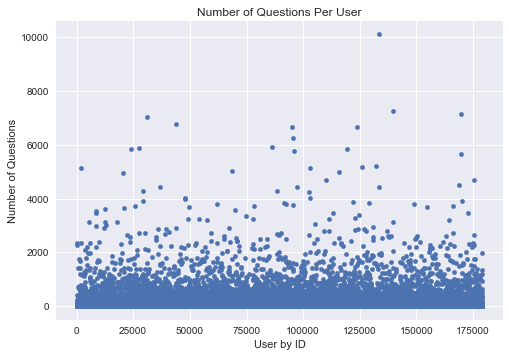

In [16]:
# Create question_count dataframe from dictionary of the labels and variables:
df_question_count = pd.DataFrame({'User by ID': question_count.index, 
                                  'Number of Questions': question_count.values})

# Create question_count scatter plot with a dictionary key selected for each axis:
df_question_count.plot(kind='scatter', x='User by ID', y='Number of Questions')

# Create the title of the plot:
plt.title('Number of Questions Per User')

# Set the limit for the y-axis:
# plt.ylim(0,2000)

# Display the plot:
plt.show() 

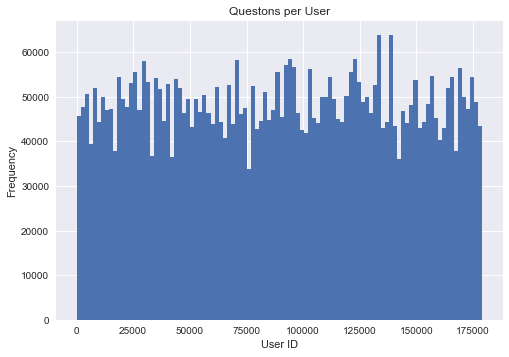

In [17]:
# Create a histogram of user_id frequency (reset the index since it is by user_id):
plt.hist(df.reset_index().user_id, 100)

# Create labels and a title:
plt.xlabel('User ID')
plt.ylabel('Frequency')
plt.title('Questons per User')

# Display the plot:
plt.show() 

In [18]:
# Set up some variables to inspect ratios and distributions of correct, incorrect:

# Save the total number of correct entries per user in the 'correct' column;
# values are 0 (incorrect) and 1 (correct), so a sum of values in the column will do:
correct_answer_count = df_by_userid['correct'].sum()

# Save the total number of incorrect entries per user by subracting correct from total:
incorrect_answer_count = question_count.subtract(correct_answer_count)

# Save the ratio of correct answers per user, dividing by total:
ratio = correct_answer_count/question_count

# Build and save the dictionary and dataframe to look at user scores:
user_score = {
    'num_questions': question_count,
    'num_correct': correct_answer_count,
    'num_incorrect': incorrect_answer_count,
    'correct_ratio': ratio
}
df_user_score = pd.DataFrame(user_score)

# Rearrange the column order:
df_user_score = df_user_score[['num_correct', 'num_incorrect', 'num_questions', 'correct_ratio']]

# Inspect the structure and values in the first 5 rows of the user score dataframe:
df_user_score.head() 

,num_correct,num_incorrect,num_questions,correct_ratio
user_id,,,,
0,5,2,7,0.714286
1,6,8,14,0.428571
2,2,6,8,0.250000
3,3,4,7,0.428571
4,7,4,11,0.636364


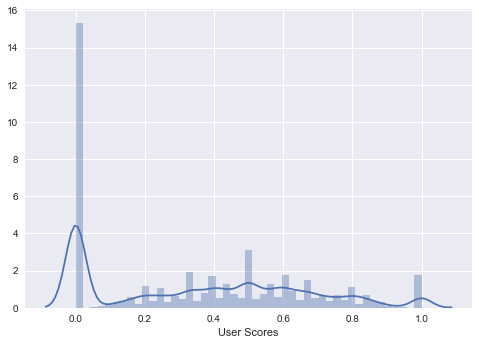

In [19]:
# Create a distribution plot of user scores (correct ratio)
sns.distplot(df_user_score.correct_ratio, axlabel='User Scores')

# Display the plot:
plt.show()  

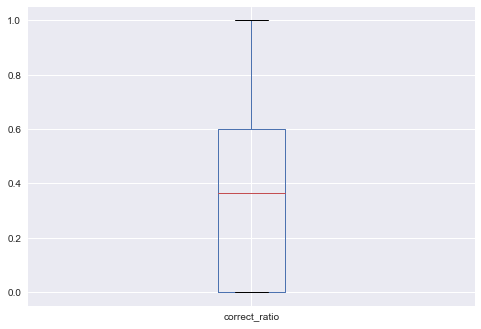

In [20]:
# Create a box plot of the user scores:
df_user_score.boxplot(column='correct_ratio')

# Display the plot:
plt.show() 

<a id='question_id' href='#top'>back to menu</a>

### question_id
---

1. How many unique questions are there?
2. How many of them are correct and incorrect?
3. Distribution of users per question?

In [21]:
# Print the number of question records in the dataset,
# and the number of unique questions asked:
print(('Question Observations:'), (len(df['question_id'])))
print(('Unique Questions:'), (len( df.question_id.unique() )))

Question Observations: 4851475
Unique Questions: 6045


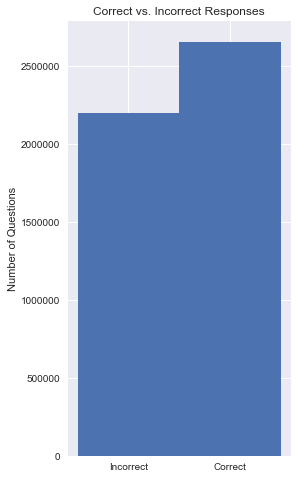

In [22]:
# Set the bin parameters:
bins = (0,1,1,2)

# Set up the overall figure dimensions and subplot arrangement:
fig, ax = plt.subplots(1,1, figsize=(4,8))

# Create the histogram from the correct column of the dataframe:
ax.hist(df.correct, bins=bins, align='left')

# Align tickmark labels and apply best fit:
ax.set_xticks(bins[:-1])
plt.autoscale(enable=True, axis='both')

# Create labels and a title:
ax.set_xticklabels(['Incorrect', 'Correct'])
plt.ylabel('Number of Questions')
plt.title('Correct vs. Incorrect Responses')

# Display the plot:
plt.show()

In [23]:
# Group the dataframe by question_id
by_questionid = df.groupby('question_id')

# Get a count of users per question_id and save:
user_count = by_questionid['question_id'].count()

# Build and save the dictionary and dataframe to look at users per question_id:
question_ids = {'num_users': user_count}
df_question_id = pd.DataFrame(question_ids)

# Inspect the structure and values in the first 5 rows of the users per question_id dataframe:
df_question_id.head()

,num_users
question_id,
0,859
1,515
2,1318
3,813
4,407


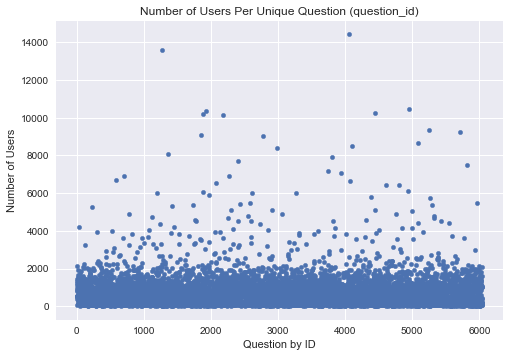

In [24]:
# Create new question_id dataframe from dictionary of the labels and variables:
df_question_ids = pd.DataFrame({'Question by ID':df_question_id.index, 
                                'Number of Users':user_count.values})

# Create question_id scatter plot with a dictionary key selected for each axis:
df_question_ids.plot(kind='scatter', x='Question by ID', y='Number of Users')

# Create the title of the plot:
plt.title('Number of Users Per Unique Question (question_id)')

# Set the limit for the y-axis:
# plt.ylim(0,2000)

# Display the plot:
plt.show()

<a id='question_type' href='#top'>back to menu</a>

### question_type
---

1. Frequency and distribution of these two categories?

In [25]:
# Count the unique values and save, then print:
question_type_count = df.question_type.value_counts()
print(question_type_count) 

0    4666507
1     184968
Name: question_type, dtype: int64


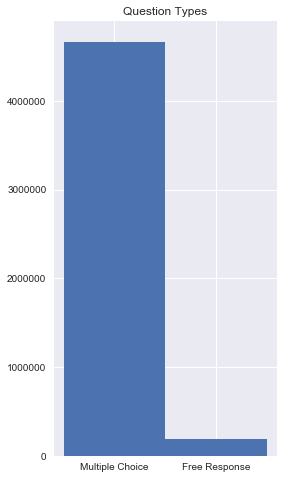

In [26]:
# Set the bin parameters:
bins = (0,1,1,2)

# Set up the overall figure dimensions and subplot arrangement:
fig, ax = plt.subplots(1,1, figsize=(4,8))

# Create the histogram from the question_type column of the dataframe:
ax.hist(df.question_type, bins=bins, align='left')

# Align tickmark labels and apply best fit:
ax.set_xticks(bins[:-1])
plt.autoscale(enable=True, axis='both')

# Create labels and a title:
ax.set_xticklabels(['Multiple Choice', 'Free Response'])
plt.title('Question Types')

# Display the plot:
plt.show() 

<a id='group_name' href='#top'>back to menu</a>

### group_name
---

1. Frequency and distribution of these categories?

<a id='track_name' href='#top'>back to menu</a>

### track_name
---

1. Frequency and distribution of these categories?

<a id='subtrack_name' href='#top'>back to menu</a>

### subtrack_name
---

<a id='tag_string' href='#top'>back to menu</a>

### tag_string
---

<a id='round_started_at' href='#top'>back to menu</a>

### round_started_at
---

[use this as reference date]

<a id='answered_at' href='#top'>back to menu</a>

### answered_at
---

[minutes from reference date]
1. What is the number of NULLs and the % of the total?

<a id='deactivated_at' href='#top'>back to menu</a>

### deactivated_at
---

[minutes from reference date]
1. Are there any NULLs?

<a id='game_type' href='#top'>back to menu</a>

### game_type
---

**`BookmarkGame: 0`** - values are like `ReviewGames`, but on specific questions the user has bookmarked.

**`ChallengeGame: 1`** - values are solo games where the user is taking a series of questions intended to challenge them and give them the best opportunities for learning.

**`CompetitiveGame: 2`** - values are the most different from other types of games. In these, once one user has answered correctly, the other users should be marked as 'skipped', and the game immediately proceeds to the next question. At the end of the game, whomever has answered the most questions correct wins.

**`ComputerAdaptiveTestGame: 3`** - values are the user answering questions on a full-length CAT, designed to mimic the algorithms used in the actual test, to ask them questions designed to maximize the information gain on the user's ability. TRYING TO IMPROVE THIS.

**`CustomGame: 4`** - values are normal games (like `PracticeGame`), but with some settings (such as specific areas or difficulty levels) chosen by the user.

**`DiagnosticGame: 5`** - values are solo games which are intended to give an initial rough assessment of the user's ability level.

**`NULL: 6`** - values represent a data collection failure.

**`PracticeGame: 7`** - is the main type of game: in these, everyone in the game is seeing the same question at the same time; once everyone has answered, the answer is displayed; once everyone is ready to continue, the round advances to a new question.  Note that these can be solo games as well.

**`RecitationGame: 8`** - represents a game led by a tutor through a series of questions, with the tutor controlling the pace of advancement.

**`ReviewGame: 9`** - is a solo game (essentially a solo `PracticeGame`) started by a user to review questions they have played in the past.

**`StudyHallGame: 10`** - is the newest type of game: in these, users are answering their own series of questions as though the were in a solo practice game, but there is a single "study hall" chat where people can ask for help on questions.

**`StudyTaskGame: 11`** - is a game where the user is answering questions in a common skill area, in order to achieve a task in their personalized study plan.

In [27]:
# Print the totals of each game_type:
print(Counter(df.game_type))

Counter({7: 3085722, 4: 831263, 5: 406752, 11: 275028, 3: 91745, 1: 72438, 2: 57916, 9: 21451, 0: 3994, 10: 2698, 8: 2081, 6: 387})


In [28]:
game_types = ['BookmarkGame', 'ChallengeGame', 'CompetitiveGame', 'ComputerAdaptiveTestGame', 'CustomGame', 'DiagnosticGame', 'NULL', 'PracticeGame', 'RecitationGame', 'ReviewGame', 'StudyHallGame', 'StudyTaskGame']

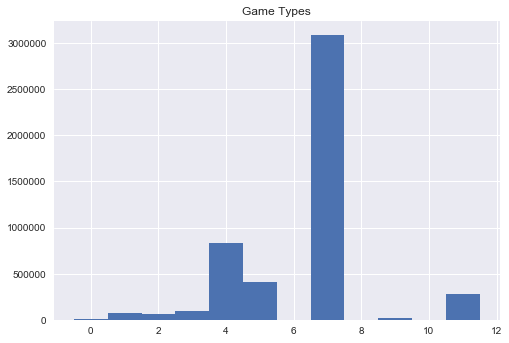

In [29]:
# Set the bin parameters:
bins = (0,1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8,9,9,10,10,11,11,12) # Surely there's a better way?

# Create a histogram of game types:
plt.hist(df.game_type, bins=bins, align='left')

# Create a title:
plt.title('Game Types')

# Display the plot:
plt.show() 

<a id='num_players' href='#top'>back to menu</a>

### num_players
---

1. Distribution of number of players per question?

<a id='date_of_test' href='#top'>back to menu</a>

### date_of_test
---

1. How many NULLs and % of the total?

### Save Clean DataFrame